In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
sns.set()  # set the style

In [2]:
df = pd.read_csv('./Data-Science-with-Python/data/smoker.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   smoker     10000 non-null  int64
 1   treatment  10000 non-null  int64
 2   outcome    10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [3]:
df.head()

,smoker,treatment,outcome
0,0,0,0
1,1,1,0
2,1,1,0
3,0,1,0
4,0,0,0


In [4]:
df.groupby('treatment')['outcome'].mean()

treatment
0    0.235134
1    0.340213
Name: outcome, dtype: float64

In [5]:
# separate control and treatment for z-test
df_control = df[df.treatment==0]
df_treatment = df[df.treatment==1]

dead_control = len(df_control.loc[df.outcome==1])
dead_treatment = len(df_treatment.loc[df.outcome==1])
total_control = len(df_control)
total_treatment = len(df_treatment)
print(dead_control, total_control)
print(dead_treatment, dead_treatment)

1645 6996
1022 1022


In [6]:


alpha = 0.05  # significant level

# z-test
z, p = proportions_ztest([dead_control, dead_treatment], nobs=[total_control, total_treatment])

# print the p value
print(f'p-value: {p:.3f}')

if p <= alpha:
    print('The result is significant: there is a difference in the conversion rate, reject H0')
else:
    print('The result is not significant: there is no difference in the conversion rate, fail to reject H0')


p-value: 0.000
The result is significant: there is a difference in the conversion rate, reject H0


In [7]:
# ate: average treatment effect
death_rate_control = df.groupby('treatment')['outcome'].mean()[0]
death_rate_treatment = df.groupby('treatment')['outcome'].mean()[1]

ate = death_rate_treatment - death_rate_control
print(f'ATE before matching is {ate:.3f}')
print(f'The percentage of deaths will increase {ate:.1%} if treated')
print('Conclusion: treatment should NOT be done')

ATE before matching is 0.105
The percentage of deaths will increase 10.5% if treated
Conclusion: treatment should NOT be done


In [8]:
# before matching treatment group has way more smokers than the control group
smoker_ratio = df.groupby('treatment')['smoker'].value_counts(normalize=True)
smoker_ratio

treatment  smoker
0          0         0.807033
           1         0.192967
1          1         0.557590
           0         0.442410
Name: proportion, dtype: float64

In [9]:
# multi-index series to dataframe
smoker_ratio = smoker_ratio.to_frame(name="ratio").reset_index()
smoker_ratio

,treatment,smoker,ratio
0,0,0,0.807033
1,0,1,0.192967
2,1,1,0.557590
3,1,0,0.442410


/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='treatment', ylabel='ratio'>

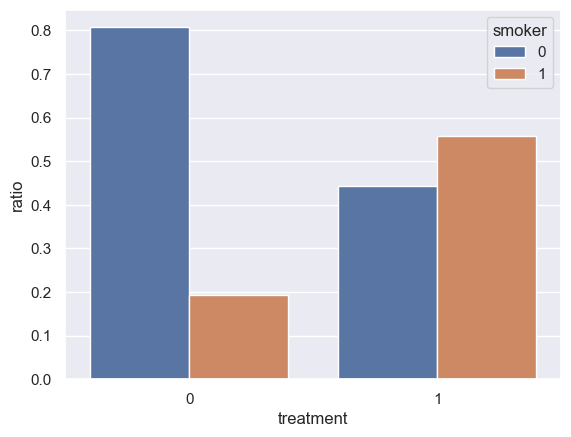

In [10]:
# sns group bar chart
sns.barplot(
    data=smoker_ratio, 
    x='treatment',
    y='ratio',
    hue='smoker',
)

Observations:¶
the treatment is not distributed equally between the smoking population and the non-smoking one
treatment is not randomized so the simple way of calculating ATE is not correct
confounding effect: a variable (smoker in this case) or a group of variables (the confounders) affects both the probability of getting the treatment and the outcome (dead or not)
Ideally, RCT (random controlled trials) should be conducted to randomly assignment treatments to reduce the confounding effect.

RCT may not be possible:

It's not ethical to do RCT. For example, estimate the effect of smoking (“treatment”) in lung health (outcome) of teenagers, it's not possible to take a number of teenagers and randomly assign half of them to forcibly smoke to do RCT.
we only have access to historical data and RCT is not possible to do.
Matching
1:1 match - for each person in treatment, we find a match from the control, i.e., if the person is a smoker, we find a smoker in the control.

In [11]:
treatment = df[df.treatment==1]
control = df[df.treatment==0]
treatment = treatment.reset_index(drop=True)

In [12]:
treatment.head()

,smoker,treatment,outcome
0,1,1,0
1,1,1,0
2,0,1,0
3,1,1,1
4,1,1,0


In [13]:
control.head()

,smoker,treatment,outcome
0,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
8,0,0,0


In [14]:
# for each person in treatment based on smoker or not, find a 1:1 match via sampling without replacement
matched_control = []

for index, row in treatment.iterrows():  # iterate over treatment group
    # .sample() random sample 1
    # .iloc[0] change dataframe to series
    # lock random state so that we get the same result for every run
    # .sample(replace=False) is the default - no replacement
    matched = control[control.smoker==row.smoker].sample(random_state=42).iloc[0]
    matched_control.append(matched)

# convert list to dataframe and reset index
matched_control = pd.DataFrame(matched_control).reset_index(drop=True)
matched_control

,smoker,treatment,outcome
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,1,0,1
...,...,...,...
2999,0,0,0
3000,0,0,0
3001,1,0,1
3002,1,0,1


In [15]:
df_matched = pd.concat([treatment, matched_control])
df_matched[['smoker', 'treatment', 'outcome']] = df_matched[['smoker', 'treatment', 'outcome']].astype(int)  # change to int
df_matched

,smoker,treatment,outcome
0,1,1,0
1,1,1,0
2,0,1,0
3,1,1,1
4,1,1,0
...,...,...,...
2999,0,0,0
3000,0,0,0
3001,1,0,1
3002,1,0,1


In [16]:
# after matching same smoker ratio in both control and treatment group
smoker_ratio_matched = df_matched.groupby('treatment')['smoker'].value_counts(normalize=True)
smoker_ratio_matched


treatment  smoker
0          1         0.55759
           0         0.44241
1          1         0.55759
           0         0.44241
Name: proportion, dtype: float64

In [17]:
smoker_ratio_matched = smoker_ratio_matched.to_frame(name="ratio").reset_index()
smoker_ratio_matched

,treatment,smoker,ratio
0,0,1,0.55759
1,0,0,0.44241
2,1,1,0.55759
3,1,0,0.44241


/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='treatment', ylabel='ratio'>

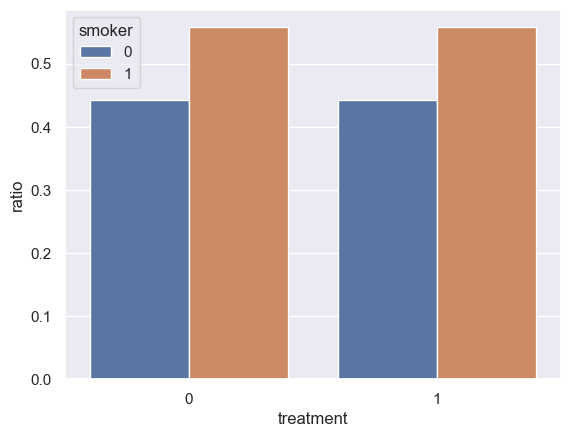

In [18]:
# sns group bar chart
sns.barplot(
    data=smoker_ratio_matched, 
    x='treatment',
    y='ratio',
    hue='smoker',
)

/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

Text(0.5, 1.0, 'After Matching')

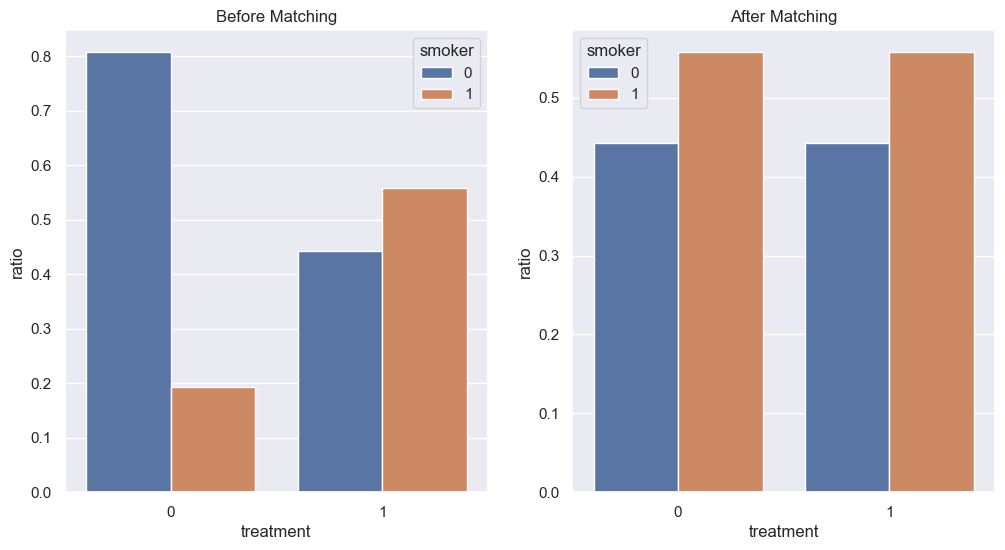

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(
    data=smoker_ratio, 
    x='treatment',
    y='ratio',
    hue='smoker',
    ax=ax[0],
)

ax[0].set_title('Before Matching')

sns.barplot(
    data=smoker_ratio_matched, 
    x='treatment',
    y='ratio',
    hue='smoker',
    ax=ax[1],
)

ax[1].set_title('After Matching')

In [20]:
df_matched.groupby('treatment')['outcome'].mean()

treatment
0    0.557590
1    0.340213
Name: outcome, dtype: float64

In [21]:
death_rate_control_matched = df_matched.groupby('treatment')['outcome'].mean()[0]
death_rate_treatment_matched = df_matched.groupby('treatment')['outcome'].mean()[1]

ate_matched = death_rate_treatment_matched - death_rate_control_matched

print(f'ATE after matching is {ate_matched:.3f}')
print(f'The percentage of deaths will decrease {ate_matched:.1%} if treated')
print('Conclusion: treatment should be done')

ATE after matching is -0.217
The percentage of deaths will decrease -21.7% if treated
Conclusion: treatment should be done
